In [1]:
import transformers
print(transformers.__version__)

import sys, os, json
sys.path.append("..")

import pandas as pd
from src.EncoderTrainer import EncoderTrainer

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


4.41.2


## Global Configuration

In [2]:
# ===== paths & constants =====
OUTPUT_FOLDER = "../outputs"
DATA_FOLDER = "../data"

#MODEL_NAMES = ["bert-base-cased", "bert-base-uncased", "microsoft/deberta-v3-base"]
#FOLDER_NAMES = ["bert-base-cased", "bert-base-uncased", "deberta-v3-base"]

#MODEL_NAMES = ["microsoft/deberta-v3-base"]
#FOLDER_NAMES = ["deberta-v3-base"]

#MODEL_NAMES = ["bert-base-cased"]
#FOLDER_NAMES = ["bert-base-cased"]

MODEL_NAMES = [
    "bert-base-cased",
    "bert-base-uncased",
    "yiyanghkust/finbert-tone"
]

FOLDER_NAMES = [
    "bert-base-cased",
    "bert-base-uncased",
    "finbert-tone"
]

TEST_JSON = f"{DATA_FOLDER}/processed/test.json"

MAX_LENGTH = 128
LABELS = ["negative", "neutral", "positive"]
NUM_LABELS = len(LABELS)

## Create Results DataFrame

In [3]:
RESULTS_DF = pd.DataFrame(columns=[
    "model",
    "experiment_type",
    "learning_rate",
    "r",
    "lora_alpha",
    "lora_dropout",
    "use_class_weights",
    "accuracy",
    "precision",
    "recall",
    "f1",
    "auc_ovr"
])


### Baseline Result

In [4]:
for MODEL_NAME, FOLDER_NAME in zip(MODEL_NAMES, FOLDER_NAMES):

    LORA_TUNING_DIR = f"{OUTPUT_FOLDER}/lora_tuning/{FOLDER_NAME}"
    
    trainer = EncoderTrainer(
        model_name=MODEL_NAME,
        labels=LABELS,
        load_in_4bit=False,
    )
    
    metrics = trainer.evaluate_classification(
        test_path=TEST_JSON,
        labels=LABELS,
        average="macro",
        verbose=False
    )
    
    # ---- store baseline ----
    baseline_row = {
        "model": MODEL_NAME,
        "experiment_type": "baseline",   # baseline full fine-tuning
        "learning_rate": None,
        "r": None,
        "lora_alpha": None,
        "lora_dropout": None,
        "use_class_weights": None,
        "accuracy": metrics["accuracy"],
        "precision": metrics["precision"],
        "recall": metrics["recall"],
        "f1": metrics["f1"],
        "auc_ovr": metrics["auc_ovr"],
    }
    
    RESULTS_DF = pd.concat(
        [RESULTS_DF, pd.DataFrame([baseline_row])],
        ignore_index=True
    )
    
    RESULTS_DF


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_11430/2266375602.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  RESULTS_DF = pd.concat(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/f

### FFT and LoRA Results

In [5]:
RESULTS_DF

,model,experiment_type,learning_rate,r,lora_alpha,lora_dropout,use_class_weights,accuracy,precision,recall,f1,auc_ovr
0,bert-base-cased,baseline,None,None,None,None,None,0.140496,0.046832,0.333333,0.082126,0.531902
1,bert-base-uncased,baseline,None,None,None,None,None,0.590909,0.196970,0.333333,0.247619,0.506018
2,yiyanghkust/finbert-tone,baseline,None,None,None,None,None,0.090909,0.136494,0.125051,0.093304,0.273484


In [6]:
for MODEL_NAME, FOLDER_NAME in zip(MODEL_NAMES, FOLDER_NAMES):

    LORA_TUNING_DIR = f"{OUTPUT_FOLDER}/lora_tuning/{FOLDER_NAME}"
    
    for folder in os.listdir(LORA_TUNING_DIR):
        folder_path = os.path.join(LORA_TUNING_DIR, folder)
    
        if not os.path.isdir(folder_path):
            continue
    
        config_path = os.path.join(folder_path, "exp_config.json")

        # Skip if no config file
        if not os.path.exists(config_path):
            print(f"Skipping {folder} (no exp_config.json)")
            continue
        
        print(folder_path)
        
        # ----------------------------------
        # Load experiment config (NO parsing)
        # ----------------------------------
        with open(config_path, "r") as f:
            cfg = json.load(f)
        
        is_lora = cfg.get("use_lora", False)
        method = "LoRA" if is_lora else "Full FT"

        print("\n" + "="*80)
        print(f"Evaluating Model      : {MODEL_NAME}")
        print(f"Fine-Tuning Method    : {method}")
        print(f"Learning Rate         : {cfg.get('learning_rate')}")
        print(f"LoRA Rank (r)         : {cfg.get('r')}")
        print(f"LoRA Alpha            : {cfg.get('lora_alpha')}")
        print(f"LoRA Dropout          : {cfg.get('lora_dropout')}")
        print(f"Class Weights Enabled : {cfg.get('use_class_weights')}")
        print("="*80)
    
        # ---- Initialize trainer ----
        trainer = EncoderTrainer(
            model_name=MODEL_NAME,
            labels=LABELS,
            load_in_4bit=False,
        )
    
        # =====================================================
        # Load model differently depending on method
        # ====================================================
        trainer.load_model(folder_path, use_lora=is_lora)
        print("After load:",
          trainer.model.classifier.weight.mean())
    
        # ---- Evaluate ----
        metrics = trainer.evaluate_classification(
            test_path=TEST_JSON,
            labels=LABELS,
            average="macro",
            verbose=True
        )
    
        row = {
            "model": MODEL_NAME,
            "experiment_type": folder,
            "learning_rate": cfg.get("learning_rate"),
            "r": cfg.get("r"),
            "lora_alpha": cfg.get("lora_alpha"),
            "lora_dropout": cfg.get("lora_dropout"),
            "use_class_weights": cfg.get("use_class_weights"),
            "accuracy": metrics["accuracy"],
            "precision": metrics["precision"],
            "recall": metrics["recall"],
            "f1": metrics["f1"],
            "auc_ovr": metrics["auc_ovr"],
        }
    
        print(metrics)
    
        RESULTS_DF = pd.concat([RESULTS_DF, pd.DataFrame([row])], ignore_index=True)


../outputs/lora_tuning/bert-base-cased/FFT_LR_0.0001_use_lora_False_learning_rate_0.0001_r_None_lora_alpha_None_lora_dropout_None_use_class_weights_False

Evaluating Model      : bert-base-cased
Fine-Tuning Method    : Full FT
Learning Rate         : 0.0001
LoRA Rank (r)         : None
LoRA Alpha            : None
LoRA Dropout          : None
Class Weights Enabled : False


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 27   3   4]
 [  1 131  11]
 [  0  15  50]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.96      0.79      0.87        34
     neutral       0.88      0.92      0.90       143
    positive       0.77      0.77      0.77        65

    accuracy                           0.86       242
   macro avg       0.87      0.83      0.85       242
weighted avg       0.86      0.86      0.86       242

{'accuracy': 0.859504132231405, 'precision': 0.8709037047963223, 'recall': 0.826477444124503, 'f1': 0.8458195950462852, 'auc_ovr': 0.9427493653049939}
../outputs/lora_tuning/bert-base-cased/FFT_LR_0.0002_use_lora_False_learning_rate_0.0002_r_None_lora_alpha_None_lora_dropout_None_use_class_weights_False

Evaluating Model      : bert-base-cased
Fine-Tuning Method    : Full FT
Learning Rate         : 0.0002
LoRA Rank (r)         : None
LoRA Alpha           

/tmp/ipykernel_11430/1622625866.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  RESULTS_DF = pd.concat([RESULTS_DF, pd.DataFrame([row])], ignore_index=True)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[  0  21  13]
 [  0 130  13]
 [  0  48  17]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        34
     neutral       0.65      0.91      0.76       143
    positive       0.40      0.26      0.31        65

    accuracy                           0.61       242
   macro avg       0.35      0.39      0.36       242
weighted avg       0.49      0.61      0.53       242

{'accuracy': 0.6074380165289256, 'precision': 0.34953838962253125, 'recall': 0.39020979020979024, 'f1': 0.3583495776478232, 'auc_ovr': 0.6445638335018491}
../outputs/lora_tuning/bert-base-cased/FFT_LR_0.0003_use_lora_False_learning_rate_0.0003_r_None_lora_alpha_None_lora_dropout_None_use_class_weights_False

Evaluating Model      : bert-base-cased
Fine-Tuning Method    : Full FT
Learning Rate         : 0.0003
LoRA Rank (r)         : None
LoRA Alpha       

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[  0  34   0]
 [  0 143   0]
 [  0  65   0]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        34
     neutral       0.59      1.00      0.74       143
    positive       0.00      0.00      0.00        65

    accuracy                           0.59       242
   macro avg       0.20      0.33      0.25       242
weighted avg       0.35      0.59      0.44       242

{'accuracy': 0.5909090909090909, 'precision': 0.196969696969697, 'recall': 0.3333333333333333, 'f1': 0.24761904761904763, 'auc_ovr': 0.5183526916982799}
../outputs/lora_tuning/bert-base-cased/FFT_LR_0.0005_use_lora_False_learning_rate_0.0005_r_None_lora_alpha_None_lora_dropout_None_use_class_weights_False

Evaluating Model      : bert-base-cased
Fine-Tuning Method    : Full FT
Learning Rate         : 0.0005
LoRA Rank (r)         : None
LoRA Alpha         

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[  0  34   0]
 [  0 143   0]
 [  0  65   0]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        34
     neutral       0.59      1.00      0.74       143
    positive       0.00      0.00      0.00        65

    accuracy                           0.59       242
   macro avg       0.20      0.33      0.25       242
weighted avg       0.35      0.59      0.44       242

{'accuracy': 0.5909090909090909, 'precision': 0.196969696969697, 'recall': 0.3333333333333333, 'f1': 0.24761904761904763, 'auc_ovr': 0.5424668424560793}
../outputs/lora_tuning/bert-base-cased/FFT_LR_0.0006_use_lora_False_learning_rate_0.0006_r_None_lora_alpha_None_lora_dropout_None_use_class_weights_False

Evaluating Model      : bert-base-cased
Fine-Tuning Method    : Full FT
Learning Rate         : 0.0006
LoRA Rank (r)         : None
LoRA Alpha         

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[  0  34   0]
 [  0 143   0]
 [  0  65   0]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        34
     neutral       0.59      1.00      0.74       143
    positive       0.00      0.00      0.00        65

    accuracy                           0.59       242
   macro avg       0.20      0.33      0.25       242
weighted avg       0.35      0.59      0.44       242

{'accuracy': 0.5909090909090909, 'precision': 0.196969696969697, 'recall': 0.3333333333333333, 'f1': 0.24761904761904763, 'auc_ovr': 0.5126942326613201}
../outputs/lora_tuning/bert-base-cased/FFT_LR_5e-05_use_lora_False_learning_rate_5e-05_r_None_lora_alpha_None_lora_dropout_None_use_class_weights_False

Evaluating Model      : bert-base-cased
Fine-Tuning Method    : Full FT
Learning Rate         : 5e-05
LoRA Rank (r)         : None
LoRA Alpha            

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


After load: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 27   3   4]
 [  2 132   9]
 [  2  17  46]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.87      0.79      0.83        34
     neutral       0.87      0.92      0.89       143
    positive       0.78      0.71      0.74        65

    accuracy                           0.85       242
   macro avg       0.84      0.81      0.82       242
weighted avg       0.84      0.85      0.84       242

{'accuracy': 0.8471074380165289, 'precision': 0.8396832705054051, 'recall': 0.8082956259426849, 'f1': 0.8225399896258289, 'auc_ovr': 0.9459523115039521}
../outputs/lora_tuning/bert-base-cased/LORA_ALPHA_16_use_lora_True_learning_rate_0.0005_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-cased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0005
LoRA Rank (r)         : 8
LoRA Alpha            : 16
LoRA

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 26   5   3]
 [  0 134   9]
 [  2  17  46]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.93      0.76      0.84        34
     neutral       0.86      0.94      0.90       143
    positive       0.79      0.71      0.75        65

    accuracy                           0.85       242
   macro avg       0.86      0.80      0.83       242
weighted avg       0.85      0.85      0.85       242

{'accuracy': 0.8512396694214877, 'precision': 0.8602164119405499, 'recall': 0.803153709036062, 'f1': 0.8276660757760884, 'auc_ovr': 0.9608195144206428}
../outputs/lora_tuning/bert-base-cased/LORA_ALPHA_32_use_lora_True_learning_rate_0.0005_r_8_lora_alpha_32_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-cased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0005
LoRA Rank (r)         : 8


/tmp/ipykernel_11430/1622625866.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  RESULTS_DF = pd.concat([RESULTS_DF, pd.DataFrame([row])], ignore_index=True)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 27   4   3]
 [  2 131  10]
 [  1  17  47]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.90      0.79      0.84        34
     neutral       0.86      0.92      0.89       143
    positive       0.78      0.72      0.75        65

    accuracy                           0.85       242
   macro avg       0.85      0.81      0.83       242
weighted avg       0.85      0.85      0.85       242

{'accuracy': 0.8471074380165289, 'precision': 0.848391812865497, 'recall': 0.8110928287398876, 'f1': 0.8279618644067797, 'auc_ovr': 0.9562474805399441}
../outputs/lora_tuning/bert-base-cased/LORA_ALPHA_8_use_lora_True_learning_rate_0.0005_r_8_lora_alpha_8_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-cased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0005
LoRA Rank (r)         : 8
Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 23   8   3]
 [  1 136   6]
 [  3  19  43]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.85      0.68      0.75        34
     neutral       0.83      0.95      0.89       143
    positive       0.83      0.66      0.74        65

    accuracy                           0.83       242
   macro avg       0.84      0.76      0.79       242
weighted avg       0.83      0.83      0.83       242

{'accuracy': 0.8347107438016529, 'precision': 0.8377102523319291, 'recall': 0.7630193336075689, 'f1': 0.7926766615291205, 'auc_ovr': 0.9533807563734827}
../outputs/lora_tuning/bert-base-cased/LORA_CLASS_WEIGHT_use_lora_True_learning_rate_0.0005_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-cased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0005
LoRA Rank (r)        

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 26   5   3]
 [  0 134   9]
 [  2  17  46]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.93      0.76      0.84        34
     neutral       0.86      0.94      0.90       143
    positive       0.79      0.71      0.75        65

    accuracy                           0.85       242
   macro avg       0.86      0.80      0.83       242
weighted avg       0.85      0.85      0.85       242

{'accuracy': 0.8512396694214877, 'precision': 0.8602164119405499, 'recall': 0.803153709036062, 'f1': 0.8276660757760884, 'auc_ovr': 0.9608195144206428}
../outputs/lora_tuning/bert-base-cased/LORA_CLASS_WEIGHT_use_lora_True_learning_rate_0.0005_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_True

Evaluating Model      : bert-base-cased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0005
LoRA Rank (r)         :

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 27   4   3]
 [  2 128  13]
 [  3  16  46]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.84      0.79      0.82        34
     neutral       0.86      0.90      0.88       143
    positive       0.74      0.71      0.72        65

    accuracy                           0.83       242
   macro avg       0.82      0.80      0.81       242
weighted avg       0.83      0.83      0.83       242

{'accuracy': 0.8305785123966942, 'precision': 0.8168501162452776, 'recall': 0.7989716166186754, 'f1': 0.8074387843037897, 'auc_ovr': 0.9477808851998782}
../outputs/lora_tuning/bert-base-cased/LORA_DROPOUT_0.05_use_lora_True_learning_rate_0.0005_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-cased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0005
LoRA Rank (r)        

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 26   5   3]
 [  0 134   9]
 [  2  17  46]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.93      0.76      0.84        34
     neutral       0.86      0.94      0.90       143
    positive       0.79      0.71      0.75        65

    accuracy                           0.85       242
   macro avg       0.86      0.80      0.83       242
weighted avg       0.85      0.85      0.85       242

{'accuracy': 0.8512396694214877, 'precision': 0.8602164119405499, 'recall': 0.803153709036062, 'f1': 0.8276660757760884, 'auc_ovr': 0.9608195144206428}
../outputs/lora_tuning/bert-base-cased/LORA_DROPOUT_0.0_use_lora_True_learning_rate_0.0005_r_8_lora_alpha_16_lora_dropout_0.0_use_class_weights_False

Evaluating Model      : bert-base-cased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0005
LoRA Rank (r)         : 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 26   6   2]
 [  1 131  11]
 [  3  16  46]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.87      0.76      0.81        34
     neutral       0.86      0.92      0.89       143
    positive       0.78      0.71      0.74        65

    accuracy                           0.84       242
   macro avg       0.83      0.80      0.81       242
weighted avg       0.84      0.84      0.84       242

{'accuracy': 0.8388429752066116, 'precision': 0.834178944647539, 'recall': 0.7961607020430549, 'f1': 0.8131902063353676, 'auc_ovr': 0.9535652644207661}
../outputs/lora_tuning/bert-base-cased/LORA_DROPOUT_0.1_use_lora_True_learning_rate_0.0005_r_8_lora_alpha_16_lora_dropout_0.1_use_class_weights_False

Evaluating Model      : bert-base-cased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0005
LoRA Rank (r)         : 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 26   5   3]
 [  1 133   9]
 [  2  16  47]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.90      0.76      0.83        34
     neutral       0.86      0.93      0.90       143
    positive       0.80      0.72      0.76        65

    accuracy                           0.85       242
   macro avg       0.85      0.81      0.83       242
weighted avg       0.85      0.85      0.85       242

{'accuracy': 0.8512396694214877, 'precision': 0.8522660857552734, 'recall': 0.8059509118332647, 'f1': 0.8263614123829178, 'auc_ovr': 0.9587546389345537}
../outputs/lora_tuning/bert-base-cased/LORA_LR_0.0001_use_lora_True_learning_rate_0.0001_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-cased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0001
LoRA Rank (r)         : 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[  0   7  27]
 [  0 134   9]
 [  0  36  29]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        34
     neutral       0.76      0.94      0.84       143
    positive       0.45      0.45      0.45        65

    accuracy                           0.67       242
   macro avg       0.40      0.46      0.43       242
weighted avg       0.57      0.67      0.61       242

{'accuracy': 0.6735537190082644, 'precision': 0.4010719976821672, 'recall': 0.46107226107226107, 'f1': 0.4278846153846154, 'auc_ovr': 0.8394200303013637}
../outputs/lora_tuning/bert-base-cased/LORA_LR_0.0002_use_lora_True_learning_rate_0.0002_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-cased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0002
LoRA Rank (r)         :

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 13   7  14]
 [  0 135   8]
 [  6  24  35]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.68      0.38      0.49        34
     neutral       0.81      0.94      0.87       143
    positive       0.61      0.54      0.57        65

    accuracy                           0.76       242
   macro avg       0.70      0.62      0.65       242
weighted avg       0.74      0.76      0.74       242

{'accuracy': 0.756198347107438, 'precision': 0.7038328753610935, 'recall': 0.6216234745646511, 'f1': 0.6460409791020393, 'auc_ovr': 0.8798384793994555}
../outputs/lora_tuning/bert-base-cased/LORA_LR_0.0003_use_lora_True_learning_rate_0.0003_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-cased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0003
LoRA Rank (r)         : 8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 21   8   5]
 [  0 133  10]
 [  4  15  46]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.84      0.62      0.71        34
     neutral       0.85      0.93      0.89       143
    positive       0.75      0.71      0.73        65

    accuracy                           0.83       242
   macro avg       0.82      0.75      0.78       242
weighted avg       0.82      0.83      0.82       242

{'accuracy': 0.8264462809917356, 'precision': 0.8155541544066134, 'recall': 0.7518030988619224, 'f1': 0.7772184146539342, 'auc_ovr': 0.9401444182028564}
../outputs/lora_tuning/bert-base-cased/LORA_LR_0.0005_use_lora_True_learning_rate_0.0005_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-cased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0005
LoRA Rank (r)         : 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 26   5   3]
 [  0 134   9]
 [  2  17  46]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.93      0.76      0.84        34
     neutral       0.86      0.94      0.90       143
    positive       0.79      0.71      0.75        65

    accuracy                           0.85       242
   macro avg       0.86      0.80      0.83       242
weighted avg       0.85      0.85      0.85       242

{'accuracy': 0.8512396694214877, 'precision': 0.8602164119405499, 'recall': 0.803153709036062, 'f1': 0.8276660757760884, 'auc_ovr': 0.9608195144206428}
../outputs/lora_tuning/bert-base-cased/LORA_LR_0.0006_use_lora_True_learning_rate_0.0006_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-cased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0006
LoRA Rank (r)         : 8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 25   6   3]
 [  1 134   8]
 [  2  16  47]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.89      0.74      0.81        34
     neutral       0.86      0.94      0.90       143
    positive       0.81      0.72      0.76        65

    accuracy                           0.85       242
   macro avg       0.85      0.80      0.82       242
weighted avg       0.85      0.85      0.85       242

{'accuracy': 0.8512396694214877, 'precision': 0.8540587764725696, 'recall': 0.7984779925956397, 'f1': 0.8223334418045875, 'auc_ovr': 0.959635578149355}
../outputs/lora_tuning/bert-base-cased/LORA_LR_5e-05_use_lora_True_learning_rate_5e-05_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-cased
Fine-Tuning Method    : LoRA
Learning Rate         : 5e-05
LoRA Rank (r)         : 8
Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[  0  34   0]
 [  0 143   0]
 [  0  65   0]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        34
     neutral       0.59      1.00      0.74       143
    positive       0.00      0.00      0.00        65

    accuracy                           0.59       242
   macro avg       0.20      0.33      0.25       242
weighted avg       0.35      0.59      0.44       242

{'accuracy': 0.5909090909090909, 'precision': 0.196969696969697, 'recall': 0.3333333333333333, 'f1': 0.24761904761904763, 'auc_ovr': 0.6604433057165768}
../outputs/lora_tuning/bert-base-cased/LORA_RANK_16_use_lora_True_learning_rate_0.0005_r_16_lora_alpha_32_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-cased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0005
LoRA Rank (r)         : 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 26   5   3]
 [  2 132   9]
 [  3  18  44]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.84      0.76      0.80        34
     neutral       0.85      0.92      0.89       143
    positive       0.79      0.68      0.73        65

    accuracy                           0.83       242
   macro avg       0.83      0.79      0.80       242
weighted avg       0.83      0.83      0.83       242

{'accuracy': 0.8347107438016529, 'precision': 0.8253456221198157, 'recall': 0.788235294117647, 'f1': 0.804392922513728, 'auc_ovr': 0.9527555692039513}
../outputs/lora_tuning/bert-base-cased/LORA_RANK_4_use_lora_True_learning_rate_0.0005_r_4_lora_alpha_8_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-cased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0005
LoRA Rank (r)         : 4
LoRA

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 25   6   3]
 [  0 136   7]
 [  4  20  41]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.86      0.74      0.79        34
     neutral       0.84      0.95      0.89       143
    positive       0.80      0.63      0.71        65

    accuracy                           0.83       242
   macro avg       0.84      0.77      0.80       242
weighted avg       0.83      0.83      0.83       242

{'accuracy': 0.8347107438016529, 'precision': 0.8351655689947327, 'recall': 0.7723707664884136, 'f1': 0.797450208021152, 'auc_ovr': 0.9500489852462343}
../outputs/lora_tuning/bert-base-cased/LORA_RANK_8_use_lora_True_learning_rate_0.0005_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-cased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0005
LoRA Rank (r)         : 8
Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 26   5   3]
 [  0 134   9]
 [  2  17  46]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.93      0.76      0.84        34
     neutral       0.86      0.94      0.90       143
    positive       0.79      0.71      0.75        65

    accuracy                           0.85       242
   macro avg       0.86      0.80      0.83       242
weighted avg       0.85      0.85      0.85       242

{'accuracy': 0.8512396694214877, 'precision': 0.8602164119405499, 'recall': 0.803153709036062, 'f1': 0.8276660757760884, 'auc_ovr': 0.9608195144206428}
../outputs/lora_tuning/bert-base-uncased/FFT_LR_0.0001_use_lora_False_learning_rate_0.0001_r_None_lora_alpha_None_lora_dropout_None_use_class_weights_False

Evaluating Model      : bert-base-uncased
Fine-Tuning Method    : Full FT
Learning Rate         : 0.0001
LoRA Rank (r)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 28   2   4]
 [  2 130  11]
 [  1  15  49]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.90      0.82      0.86        34
     neutral       0.88      0.91      0.90       143
    positive       0.77      0.75      0.76        65

    accuracy                           0.86       242
   macro avg       0.85      0.83      0.84       242
weighted avg       0.86      0.86      0.85       242

{'accuracy': 0.8553719008264463, 'precision': 0.8510681826494038, 'recall': 0.8288221582339229, 'f1': 0.8392600360523376, 'auc_ovr': 0.945194005525511}
../outputs/lora_tuning/bert-base-uncased/FFT_LR_0.0002_use_lora_False_learning_rate_0.0002_r_None_lora_alpha_None_lora_dropout_None_use_class_weights_False

Evaluating Model      : bert-base-uncased
Fine-Tuning Method    : Full FT
Learning Rate         : 0.0002
LoRA Rank (r)         : None
LoRA Alpha      

/tmp/ipykernel_11430/1622625866.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  RESULTS_DF = pd.concat([RESULTS_DF, pd.DataFrame([row])], ignore_index=True)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 26   5   3]
 [  2 131  10]
 [  4  17  44]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.81      0.76      0.79        34
     neutral       0.86      0.92      0.89       143
    positive       0.77      0.68      0.72        65

    accuracy                           0.83       242
   macro avg       0.81      0.79      0.80       242
weighted avg       0.83      0.83      0.83       242

{'accuracy': 0.8305785123966942, 'precision': 0.8135463249627337, 'recall': 0.7859042917866447, 'f1': 0.7981084661412531, 'auc_ovr': 0.9337821695963181}
../outputs/lora_tuning/bert-base-uncased/FFT_LR_0.0003_use_lora_False_learning_rate_0.0003_r_None_lora_alpha_None_lora_dropout_None_use_class_weights_False

Evaluating Model      : bert-base-uncased
Fine-Tuning Method    : Full FT
Learning Rate         : 0.0003
LoRA Rank (r)         : None
LoRA Alpha     

/tmp/ipykernel_11430/1622625866.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  RESULTS_DF = pd.concat([RESULTS_DF, pd.DataFrame([row])], ignore_index=True)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[  0  32   2]
 [  0 142   1]
 [  0  62   3]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        34
     neutral       0.60      0.99      0.75       143
    positive       0.50      0.05      0.08        65

    accuracy                           0.60       242
   macro avg       0.37      0.35      0.28       242
weighted avg       0.49      0.60      0.47       242

{'accuracy': 0.5991735537190083, 'precision': 0.3672316384180791, 'recall': 0.3463869463869464, 'f1': 0.27794913721555364, 'auc_ovr': 0.5963509265591656}
../outputs/lora_tuning/bert-base-uncased/FFT_LR_0.0005_use_lora_False_learning_rate_0.0005_r_None_lora_alpha_None_lora_dropout_None_use_class_weights_False

Evaluating Model      : bert-base-uncased
Fine-Tuning Method    : Full FT
Learning Rate         : 0.0005
LoRA Rank (r)         : None
LoRA Alpha    

/tmp/ipykernel_11430/1622625866.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  RESULTS_DF = pd.concat([RESULTS_DF, pd.DataFrame([row])], ignore_index=True)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[  0  34   0]
 [  0 143   0]
 [  0  65   0]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        34
     neutral       0.59      1.00      0.74       143
    positive       0.00      0.00      0.00        65

    accuracy                           0.59       242
   macro avg       0.20      0.33      0.25       242
weighted avg       0.35      0.59      0.44       242

{'accuracy': 0.5909090909090909, 'precision': 0.196969696969697, 'recall': 0.3333333333333333, 'f1': 0.24761904761904763, 'auc_ovr': 0.4904442401117149}
../outputs/lora_tuning/bert-base-uncased/FFT_LR_0.0006_use_lora_False_learning_rate_0.0006_r_None_lora_alpha_None_lora_dropout_None_use_class_weights_False

Evaluating Model      : bert-base-uncased
Fine-Tuning Method    : Full FT
Learning Rate         : 0.0006
LoRA Rank (r)         : None
LoRA Alpha     

/tmp/ipykernel_11430/1622625866.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  RESULTS_DF = pd.concat([RESULTS_DF, pd.DataFrame([row])], ignore_index=True)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[  0  34   0]
 [  0 143   0]
 [  0  65   0]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        34
     neutral       0.59      1.00      0.74       143
    positive       0.00      0.00      0.00        65

    accuracy                           0.59       242
   macro avg       0.20      0.33      0.25       242
weighted avg       0.35      0.59      0.44       242

{'accuracy': 0.5909090909090909, 'precision': 0.196969696969697, 'recall': 0.3333333333333333, 'f1': 0.24761904761904763, 'auc_ovr': 0.3938685146116829}
../outputs/lora_tuning/bert-base-uncased/FFT_LR_5e-05_use_lora_False_learning_rate_5e-05_r_None_lora_alpha_None_lora_dropout_None_use_class_weights_False

Evaluating Model      : bert-base-uncased
Fine-Tuning Method    : Full FT
Learning Rate         : 5e-05
LoRA Rank (r)         : None
LoRA Alpha        

/tmp/ipykernel_11430/1622625866.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  RESULTS_DF = pd.concat([RESULTS_DF, pd.DataFrame([row])], ignore_index=True)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


After load: tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 26   4   4]
 [  2 128  13]
 [  1  16  48]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.90      0.76      0.83        34
     neutral       0.86      0.90      0.88       143
    positive       0.74      0.74      0.74        65

    accuracy                           0.83       242
   macro avg       0.83      0.80      0.81       242
weighted avg       0.84      0.83      0.83       242

{'accuracy': 0.8347107438016529, 'precision': 0.8332927091547782, 'recall': 0.7994241053064582, 'f1': 0.8145278165896723, 'auc_ovr': 0.954726778641965}
../outputs/lora_tuning/bert-base-uncased/LORA_ALPHA_16_use_lora_True_learning_rate_0.0005_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-uncased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0005
LoRA Rank (r)         : 8
LoRA Alpha            : 16
L

/tmp/ipykernel_11430/1622625866.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  RESULTS_DF = pd.concat([RESULTS_DF, pd.DataFrame([row])], ignore_index=True)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 25   5   4]
 [  2 128  13]
 [  1  14  50]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.89      0.74      0.81        34
     neutral       0.87      0.90      0.88       143
    positive       0.75      0.77      0.76        65

    accuracy                           0.84       242
   macro avg       0.84      0.80      0.82       242
weighted avg       0.84      0.84      0.84       242

{'accuracy': 0.8388429752066116, 'precision': 0.8366246996310962, 'recall': 0.799876593994241, 'f1': 0.8155953303895461, 'auc_ovr': 0.9577973182064318}
../outputs/lora_tuning/bert-base-uncased/LORA_ALPHA_32_use_lora_True_learning_rate_0.0005_r_8_lora_alpha_32_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-uncased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0005
LoRA Rank (r)         

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 27   4   3]
 [  3 131   9]
 [  1  14  50]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.87      0.79      0.83        34
     neutral       0.88      0.92      0.90       143
    positive       0.81      0.77      0.79        65

    accuracy                           0.86       242
   macro avg       0.85      0.83      0.84       242
weighted avg       0.86      0.86      0.86       242

{'accuracy': 0.859504132231405, 'precision': 0.852204661903731, 'recall': 0.826477444124503, 'f1': 0.8384770265149943, 'auc_ovr': 0.959649915097776}
../outputs/lora_tuning/bert-base-uncased/LORA_ALPHA_8_use_lora_True_learning_rate_0.0005_r_8_lora_alpha_8_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-uncased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0005
LoRA Rank (r)         : 8
L

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 27   4   3]
 [  1 131  11]
 [  1  14  50]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.93      0.79      0.86        34
     neutral       0.88      0.92      0.90       143
    positive       0.78      0.77      0.78        65

    accuracy                           0.86       242
   macro avg       0.86      0.83      0.84       242
weighted avg       0.86      0.86      0.86       242

{'accuracy': 0.859504132231405, 'precision': 0.8638263712103679, 'recall': 0.826477444124503, 'f1': 0.8431989765216907, 'auc_ovr': 0.9603166680763436}
../outputs/lora_tuning/bert-base-uncased/LORA_CLASS_WEIGHT_use_lora_True_learning_rate_0.0005_r_8_lora_alpha_32_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-uncased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0005
LoRA Rank (r)      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 27   4   3]
 [  3 131   9]
 [  1  14  50]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.87      0.79      0.83        34
     neutral       0.88      0.92      0.90       143
    positive       0.81      0.77      0.79        65

    accuracy                           0.86       242
   macro avg       0.85      0.83      0.84       242
weighted avg       0.86      0.86      0.86       242

{'accuracy': 0.859504132231405, 'precision': 0.852204661903731, 'recall': 0.826477444124503, 'f1': 0.8384770265149943, 'auc_ovr': 0.959649915097776}
../outputs/lora_tuning/bert-base-uncased/LORA_CLASS_WEIGHT_use_lora_True_learning_rate_0.0005_r_8_lora_alpha_32_lora_dropout_0.05_use_class_weights_True

Evaluating Model      : bert-base-uncased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0005
LoRA Rank (r)         

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 27   4   3]
 [  3 127  13]
 [  1  10  54]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.87      0.79      0.83        34
     neutral       0.90      0.89      0.89       143
    positive       0.77      0.83      0.80        65

    accuracy                           0.86       242
   macro avg       0.85      0.84      0.84       242
weighted avg       0.86      0.86      0.86       242

{'accuracy': 0.859504132231405, 'precision': 0.8477018444074038, 'recall': 0.8376662553133142, 'f1': 0.841711809317443, 'auc_ovr': 0.9596350754897841}
../outputs/lora_tuning/bert-base-uncased/LORA_DROPOUT_0.05_use_lora_True_learning_rate_0.0005_r_8_lora_alpha_32_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-uncased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0005
LoRA Rank (r)      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 27   4   3]
 [  3 131   9]
 [  1  14  50]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.87      0.79      0.83        34
     neutral       0.88      0.92      0.90       143
    positive       0.81      0.77      0.79        65

    accuracy                           0.86       242
   macro avg       0.85      0.83      0.84       242
weighted avg       0.86      0.86      0.86       242

{'accuracy': 0.859504132231405, 'precision': 0.852204661903731, 'recall': 0.826477444124503, 'f1': 0.8384770265149943, 'auc_ovr': 0.959649915097776}
../outputs/lora_tuning/bert-base-uncased/LORA_DROPOUT_0.0_use_lora_True_learning_rate_0.0005_r_8_lora_alpha_32_lora_dropout_0.0_use_class_weights_False

Evaluating Model      : bert-base-uncased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0005
LoRA Rank (r)         :

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 29   3   2]
 [  3 130  10]
 [  1  16  48]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.88      0.85      0.87        34
     neutral       0.87      0.91      0.89       143
    positive       0.80      0.74      0.77        65

    accuracy                           0.86       242
   macro avg       0.85      0.83      0.84       242
weighted avg       0.85      0.86      0.85       242

{'accuracy': 0.8553719008264463, 'precision': 0.8504237000881295, 'recall': 0.8334978746743452, 'f1': 0.8413608668983846, 'auc_ovr': 0.9611476402008217}
../outputs/lora_tuning/bert-base-uncased/LORA_DROPOUT_0.1_use_lora_True_learning_rate_0.0005_r_8_lora_alpha_32_lora_dropout_0.1_use_class_weights_False

Evaluating Model      : bert-base-uncased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0005
LoRA Rank (r)      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 28   2   4]
 [  3 129  11]
 [  1  13  51]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.88      0.82      0.85        34
     neutral       0.90      0.90      0.90       143
    positive       0.77      0.78      0.78        65

    accuracy                           0.86       242
   macro avg       0.85      0.84      0.84       242
weighted avg       0.86      0.86      0.86       242

{'accuracy': 0.859504132231405, 'precision': 0.8478535353535355, 'recall': 0.8367475661593309, 'f1': 0.8420218355053581, 'auc_ovr': 0.9539088918054294}
../outputs/lora_tuning/bert-base-uncased/LORA_LR_0.0001_use_lora_True_learning_rate_0.0001_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-uncased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0001
LoRA Rank (r)        

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 10   7  17]
 [  1 134   8]
 [ 13  33  19]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.42      0.29      0.34        34
     neutral       0.77      0.94      0.85       143
    positive       0.43      0.29      0.35        65

    accuracy                           0.67       242
   macro avg       0.54      0.51      0.51       242
weighted avg       0.63      0.67      0.64       242

{'accuracy': 0.6735537190082644, 'precision': 0.5395332636711947, 'recall': 0.5078294254764844, 'f1': 0.5129591023085974, 'auc_ovr': 0.8305928795692458}
../outputs/lora_tuning/bert-base-uncased/LORA_LR_0.0002_use_lora_True_learning_rate_0.0002_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-uncased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0002
LoRA Rank (r)       

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 12   3  19]
 [  0 134   9]
 [  1  23  41]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.92      0.35      0.51        34
     neutral       0.84      0.94      0.88       143
    positive       0.59      0.63      0.61        65

    accuracy                           0.77       242
   macro avg       0.78      0.64      0.67       242
weighted avg       0.78      0.77      0.76       242

{'accuracy': 0.7727272727272727, 'precision': 0.7849266072092159, 'recall': 0.640257781434252, 'f1': 0.669022348408229, 'auc_ovr': 0.9078385426001668}
../outputs/lora_tuning/bert-base-uncased/LORA_LR_0.0003_use_lora_True_learning_rate_0.0003_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-uncased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0003
LoRA Rank (r)         

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 27   4   3]
 [  1 132  10]
 [  3  16  46]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.87      0.79      0.83        34
     neutral       0.87      0.92      0.89       143
    positive       0.78      0.71      0.74        65

    accuracy                           0.85       242
   macro avg       0.84      0.81      0.82       242
weighted avg       0.84      0.85      0.84       242

{'accuracy': 0.8471074380165289, 'precision': 0.8396832705054051, 'recall': 0.8082956259426849, 'f1': 0.8225399896258289, 'auc_ovr': 0.9540329750664656}
../outputs/lora_tuning/bert-base-uncased/LORA_LR_0.0005_use_lora_True_learning_rate_0.0005_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-uncased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0005
LoRA Rank (r)       

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 25   5   4]
 [  2 128  13]
 [  1  14  50]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.89      0.74      0.81        34
     neutral       0.87      0.90      0.88       143
    positive       0.75      0.77      0.76        65

    accuracy                           0.84       242
   macro avg       0.84      0.80      0.82       242
weighted avg       0.84      0.84      0.84       242

{'accuracy': 0.8388429752066116, 'precision': 0.8366246996310962, 'recall': 0.799876593994241, 'f1': 0.8155953303895461, 'auc_ovr': 0.9577973182064318}
../outputs/lora_tuning/bert-base-uncased/LORA_LR_0.0006_use_lora_True_learning_rate_0.0006_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-uncased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0006
LoRA Rank (r)        

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 25   5   4]
 [  3 127  13]
 [  1  15  49]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.86      0.74      0.79        34
     neutral       0.86      0.89      0.88       143
    positive       0.74      0.75      0.75        65

    accuracy                           0.83       242
   macro avg       0.82      0.79      0.81       242
weighted avg       0.83      0.83      0.83       242

{'accuracy': 0.8305785123966942, 'precision': 0.8228129287242588, 'recall': 0.7924173865350337, 'f1': 0.8058681552232487, 'auc_ovr': 0.9586009204732581}
../outputs/lora_tuning/bert-base-uncased/LORA_LR_5e-05_use_lora_True_learning_rate_5e-05_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-uncased
Fine-Tuning Method    : LoRA
Learning Rate         : 5e-05
LoRA Rank (r)         :

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[  0  34   0]
 [  0 143   0]
 [  0  65   0]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        34
     neutral       0.59      1.00      0.74       143
    positive       0.00      0.00      0.00        65

    accuracy                           0.59       242
   macro avg       0.20      0.33      0.25       242
weighted avg       0.35      0.59      0.44       242

{'accuracy': 0.5909090909090909, 'precision': 0.196969696969697, 'recall': 0.3333333333333333, 'f1': 0.24761904761904763, 'auc_ovr': 0.6352964355150977}
../outputs/lora_tuning/bert-base-uncased/LORA_RANK_16_use_lora_True_learning_rate_0.0005_r_16_lora_alpha_32_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-uncased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0005
LoRA Rank (r)        

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 27   4   3]
 [  3 127  13]
 [  0  14  51]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.90      0.79      0.84        34
     neutral       0.88      0.89      0.88       143
    positive       0.76      0.78      0.77        65

    accuracy                           0.85       242
   macro avg       0.85      0.82      0.83       242
weighted avg       0.85      0.85      0.85       242

{'accuracy': 0.8471074380165289, 'precision': 0.8456853662720878, 'recall': 0.8222816399286987, 'f1': 0.8328072390572391, 'auc_ovr': 0.9582749350310303}
../outputs/lora_tuning/bert-base-uncased/LORA_RANK_4_use_lora_True_learning_rate_0.0005_r_4_lora_alpha_8_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-uncased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0005
LoRA Rank (r)         : 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 30   2   2]
 [  4 129  10]
 [  4  19  42]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.79      0.88      0.83        34
     neutral       0.86      0.90      0.88       143
    positive       0.78      0.65      0.71        65

    accuracy                           0.83       242
   macro avg       0.81      0.81      0.81       242
weighted avg       0.83      0.83      0.83       242

{'accuracy': 0.8305785123966942, 'precision': 0.8090838206627681, 'recall': 0.8102015631427396, 'f1': 0.8065872537866113, 'auc_ovr': 0.953228922078623}
../outputs/lora_tuning/bert-base-uncased/LORA_RANK_8_use_lora_True_learning_rate_0.0005_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : bert-base-uncased
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0005
LoRA Rank (r)         : 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded LoRA model successfully.
After load: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 25   5   4]
 [  2 128  13]
 [  1  14  50]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.89      0.74      0.81        34
     neutral       0.87      0.90      0.88       143
    positive       0.75      0.77      0.76        65

    accuracy                           0.84       242
   macro avg       0.84      0.80      0.82       242
weighted avg       0.84      0.84      0.84       242

{'accuracy': 0.8388429752066116, 'precision': 0.8366246996310962, 'recall': 0.799876593994241, 'f1': 0.8155953303895461, 'auc_ovr': 0.9577973182064318}
../outputs/lora_tuning/finbert-tone/FFT_LR_0.0001_use_lora_False_learning_rate_0.0001_r_None_lora_alpha_None_lora_dropout_None_use_class_weights_False

Evaluating Model      : yiyanghkust/finbert-tone
Fine-Tuning Method    : Full FT
Learning Rate         : 0.0001
LoRA Rank (

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


After load: tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 28   2   4]
 [  2 133   8]
 [  1  15  49]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.90      0.82      0.86        34
     neutral       0.89      0.93      0.91       143
    positive       0.80      0.75      0.78        65

    accuracy                           0.87       242
   macro avg       0.86      0.84      0.85       242
weighted avg       0.87      0.87      0.87       242

{'accuracy': 0.8677685950413223, 'precision': 0.8643903872142898, 'recall': 0.83581516522693, 'f1': 0.8490553562225918, 'auc_ovr': 0.9565768242352127}
../outputs/lora_tuning/finbert-tone/FFT_LR_0.0002_use_lora_False_learning_rate_0.0002_r_None_lora_alpha_None_lora_dropout_None_use_class_weights_False

Evaluating Model      : yiyanghkust/finbert-tone
Fine-Tuning Method    : Full FT
Learning Rate         : 0.0002
LoRA Rank (r)         : None
LoRA Alpha     

/tmp/ipykernel_11430/1622625866.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  RESULTS_DF = pd.concat([RESULTS_DF, pd.DataFrame([row])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


After load: tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 28   3   3]
 [  2 132   9]
 [  2  22  41]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.88      0.82      0.85        34
     neutral       0.84      0.92      0.88       143
    positive       0.77      0.63      0.69        65

    accuracy                           0.83       242
   macro avg       0.83      0.79      0.81       242
weighted avg       0.83      0.83      0.83       242

{'accuracy': 0.8305785123966942, 'precision': 0.8297830789568561, 'recall': 0.7924585218702865, 'f1': 0.8078000342407122, 'auc_ovr': 0.9228464984129808}
../outputs/lora_tuning/finbert-tone/FFT_LR_0.0003_use_lora_False_learning_rate_0.0003_r_None_lora_alpha_None_lora_dropout_None_use_class_weights_False

Evaluating Model      : yiyanghkust/finbert-tone
Fine-Tuning Method    : Full FT
Learning Rate         : 0.0003
LoRA Rank (r)         : None
LoRA Alpha   

/tmp/ipykernel_11430/1622625866.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  RESULTS_DF = pd.concat([RESULTS_DF, pd.DataFrame([row])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


After load: tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[  0  34   0]
 [  0 143   0]
 [  0  65   0]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        34
     neutral       0.59      1.00      0.74       143
    positive       0.00      0.00      0.00        65

    accuracy                           0.59       242
   macro avg       0.20      0.33      0.25       242
weighted avg       0.35      0.59      0.44       242

{'accuracy': 0.5909090909090909, 'precision': 0.196969696969697, 'recall': 0.3333333333333333, 'f1': 0.24761904761904763, 'auc_ovr': 0.5107218068487669}
../outputs/lora_tuning/finbert-tone/FFT_LR_0.0005_use_lora_False_learning_rate_0.0005_r_None_lora_alpha_None_lora_dropout_None_use_class_weights_False

Evaluating Model      : yiyanghkust/finbert-tone
Fine-Tuning Method    : Full FT
Learning Rate         : 0.0005
LoRA Rank (r)         : None
LoRA Alpha   

/tmp/ipykernel_11430/1622625866.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  RESULTS_DF = pd.concat([RESULTS_DF, pd.DataFrame([row])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


After load: tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[  0  34   0]
 [  0 143   0]
 [  0  65   0]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        34
     neutral       0.59      1.00      0.74       143
    positive       0.00      0.00      0.00        65

    accuracy                           0.59       242
   macro avg       0.20      0.33      0.25       242
weighted avg       0.35      0.59      0.44       242

{'accuracy': 0.5909090909090909, 'precision': 0.196969696969697, 'recall': 0.3333333333333333, 'f1': 0.24761904761904763, 'auc_ovr': 0.3306450002755971}
../outputs/lora_tuning/finbert-tone/FFT_LR_0.0006_use_lora_False_learning_rate_0.0006_r_None_lora_alpha_None_lora_dropout_None_use_class_weights_False

Evaluating Model      : yiyanghkust/finbert-tone
Fine-Tuning Method    : Full FT
Learning Rate         : 0.0006
LoRA Rank (r)         : None
LoRA Alpha   

/tmp/ipykernel_11430/1622625866.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  RESULTS_DF = pd.concat([RESULTS_DF, pd.DataFrame([row])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


After load: tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[  0  34   0]
 [  0 143   0]
 [  0  65   0]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        34
     neutral       0.59      1.00      0.74       143
    positive       0.00      0.00      0.00        65

    accuracy                           0.59       242
   macro avg       0.20      0.33      0.25       242
weighted avg       0.35      0.59      0.44       242

{'accuracy': 0.5909090909090909, 'precision': 0.196969696969697, 'recall': 0.3333333333333333, 'f1': 0.24761904761904763, 'auc_ovr': 0.5876820435335232}
../outputs/lora_tuning/finbert-tone/FFT_LR_5e-05_use_lora_False_learning_rate_5e-05_r_None_lora_alpha_None_lora_dropout_None_use_class_weights_False

Evaluating Model      : yiyanghkust/finbert-tone
Fine-Tuning Method    : Full FT
Learning Rate         : 5e-05
LoRA Rank (r)         : None
LoRA Alpha      

/tmp/ipykernel_11430/1622625866.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  RESULTS_DF = pd.concat([RESULTS_DF, pd.DataFrame([row])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


After load: tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 30   2   2]
 [  3 129  11]
 [  1  12  52]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.88      0.88      0.88        34
     neutral       0.90      0.90      0.90       143
    positive       0.80      0.80      0.80        65

    accuracy                           0.87       242
   macro avg       0.86      0.86      0.86       242
weighted avg       0.87      0.87      0.87       242

{'accuracy': 0.871900826446281, 'precision': 0.8614836144247908, 'recall': 0.8614836144247908, 'f1': 0.8614836144247908, 'auc_ovr': 0.9554420457517984}
../outputs/lora_tuning/finbert-tone/LORA_ALPHA_16_use_lora_True_learning_rate_0.0006_r_16_lora_alpha_16_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : yiyanghkust/finbert-tone
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0006
LoRA Rank (r)         : 16
LoRA Alpha            : 

/tmp/ipykernel_11430/1622625866.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  RESULTS_DF = pd.concat([RESULTS_DF, pd.DataFrame([row])], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded LoRA model successfully.
After load: tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 26   4   4]
 [  4 131   8]
 [  2  22  41]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.81      0.76      0.79        34
     neutral       0.83      0.92      0.87       143
    positive       0.77      0.63      0.69        65

    accuracy                           0.82       242
   macro avg       0.81      0.77      0.79       242
weighted avg       0.81      0.82      0.81       242

{'accuracy': 0.8181818181818182, 'precision': 0.8068266033729921, 'recall': 0.7705196764020293, 'f1': 0.7853757918164698, 'auc_ovr': 0.943796279599665}
../outputs/lora_tuning/finbert-tone/LORA_ALPHA_32_use_lora_True_learning_rate_0.0006_r_16_lora_alpha_32_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : yiyanghkust/finbert-tone
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0006
LoRA Rank (r)      

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded LoRA model successfully.
After load: tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 26   3   5]
 [  2 134   7]
 [  1  22  42]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.90      0.76      0.83        34
     neutral       0.84      0.94      0.89       143
    positive       0.78      0.65      0.71        65

    accuracy                           0.83       242
   macro avg       0.84      0.78      0.81       242
weighted avg       0.83      0.83      0.83       242

{'accuracy': 0.8347107438016529, 'precision': 0.839032265837731, 'recall': 0.7826408885232414, 'f1': 0.8062321322936827, 'auc_ovr': 0.9441275888904593}
../outputs/lora_tuning/finbert-tone/LORA_ALPHA_64_use_lora_True_learning_rate_0.0006_r_16_lora_alpha_64_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : yiyanghkust/finbert-tone
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0006
LoRA Rank (r)      

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded LoRA model successfully.
After load: tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 26   4   4]
 [  2 133   8]
 [  2  21  42]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.87      0.76      0.81        34
     neutral       0.84      0.93      0.88       143
    positive       0.78      0.65      0.71        65

    accuracy                           0.83       242
   macro avg       0.83      0.78      0.80       242
weighted avg       0.83      0.83      0.83       242

{'accuracy': 0.8305785123966942, 'precision': 0.8287388654477262, 'recall': 0.7803098861922391, 'f1': 0.8007010943912448, 'auc_ovr': 0.9503514598360742}
../outputs/lora_tuning/finbert-tone/LORA_CLASS_WEIGHT_use_lora_True_learning_rate_0.0006_r_16_lora_alpha_64_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : yiyanghkust/finbert-tone
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0006
LoRA Rank (r) 

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded LoRA model successfully.
After load: tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 26   4   4]
 [  2 133   8]
 [  2  21  42]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.87      0.76      0.81        34
     neutral       0.84      0.93      0.88       143
    positive       0.78      0.65      0.71        65

    accuracy                           0.83       242
   macro avg       0.83      0.78      0.80       242
weighted avg       0.83      0.83      0.83       242

{'accuracy': 0.8305785123966942, 'precision': 0.8287388654477262, 'recall': 0.7803098861922391, 'f1': 0.8007010943912448, 'auc_ovr': 0.9503514598360742}
../outputs/lora_tuning/finbert-tone/LORA_CLASS_WEIGHT_use_lora_True_learning_rate_0.0006_r_16_lora_alpha_64_lora_dropout_0.05_use_class_weights_True

Evaluating Model      : yiyanghkust/finbert-tone
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0006
LoRA Rank (r)  

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded LoRA model successfully.
After load: tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 26   3   5]
 [  2 124  17]
 [  2  19  44]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.87      0.76      0.81        34
     neutral       0.85      0.87      0.86       143
    positive       0.67      0.68      0.67        65

    accuracy                           0.80       242
   macro avg       0.79      0.77      0.78       242
weighted avg       0.80      0.80      0.80       242

{'accuracy': 0.8016528925619835, 'precision': 0.7942161339421613, 'recall': 0.7695872754696284, 'f1': 0.7807957376933711, 'auc_ovr': 0.9426162594073633}
../outputs/lora_tuning/finbert-tone/LORA_DROPOUT_0.05_use_lora_True_learning_rate_0.0006_r_16_lora_alpha_64_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : yiyanghkust/finbert-tone
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0006
LoRA Rank (r) 

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded LoRA model successfully.
After load: tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 26   4   4]
 [  2 133   8]
 [  2  21  42]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.87      0.76      0.81        34
     neutral       0.84      0.93      0.88       143
    positive       0.78      0.65      0.71        65

    accuracy                           0.83       242
   macro avg       0.83      0.78      0.80       242
weighted avg       0.83      0.83      0.83       242

{'accuracy': 0.8305785123966942, 'precision': 0.8287388654477262, 'recall': 0.7803098861922391, 'f1': 0.8007010943912448, 'auc_ovr': 0.9503514598360742}
../outputs/lora_tuning/finbert-tone/LORA_DROPOUT_0.0_use_lora_True_learning_rate_0.0006_r_16_lora_alpha_64_lora_dropout_0.0_use_class_weights_False

Evaluating Model      : yiyanghkust/finbert-tone
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0006
LoRA Rank (r)   

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded LoRA model successfully.
After load: tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 27   2   5]
 [  4 127  12]
 [  1  15  49]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.84      0.79      0.82        34
     neutral       0.88      0.89      0.89       143
    positive       0.74      0.75      0.75        65

    accuracy                           0.84       242
   macro avg       0.82      0.81      0.82       242
weighted avg       0.84      0.84      0.84       242

{'accuracy': 0.8388429752066116, 'precision': 0.8227062289562289, 'recall': 0.8120252296722885, 'f1': 0.8170969476126803, 'auc_ovr': 0.9526583130866871}
../outputs/lora_tuning/finbert-tone/LORA_DROPOUT_0.1_use_lora_True_learning_rate_0.0006_r_16_lora_alpha_64_lora_dropout_0.1_use_class_weights_False

Evaluating Model      : yiyanghkust/finbert-tone
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0006
LoRA Rank (r)   

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded LoRA model successfully.
After load: tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 26   4   4]
 [  4 127  12]
 [  1  21  43]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.84      0.76      0.80        34
     neutral       0.84      0.89      0.86       143
    positive       0.73      0.66      0.69        65

    accuracy                           0.81       242
   macro avg       0.80      0.77      0.78       242
weighted avg       0.81      0.81      0.81       242

{'accuracy': 0.8099173553719008, 'precision': 0.8010165175102874, 'recall': 0.7714520773344303, 'f1': 0.7848551120831054, 'auc_ovr': 0.9406481406067874}
../outputs/lora_tuning/finbert-tone/LORA_LR_0.0001_use_lora_True_learning_rate_0.0001_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : yiyanghkust/finbert-tone
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0001
LoRA Rank (r)     

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded LoRA model successfully.
After load: tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[  9   2  23]
 [  6 127  10]
 [ 12  37  16]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.33      0.26      0.30        34
     neutral       0.77      0.89      0.82       143
    positive       0.33      0.25      0.28        65

    accuracy                           0.63       242
   macro avg       0.47      0.47      0.47       242
weighted avg       0.59      0.63      0.60       242

{'accuracy': 0.628099173553719, 'precision': 0.4749747288473622, 'recall': 0.4663238722062251, 'f1': 0.4659300646969964, 'auc_ovr': 0.7256115387737566}
../outputs/lora_tuning/finbert-tone/LORA_LR_0.0002_use_lora_True_learning_rate_0.0002_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : yiyanghkust/finbert-tone
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0002
LoRA Rank (r)      

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded LoRA model successfully.
After load: tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[  9   5  20]
 [  4 133   6]
 [  5  29  31]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.50      0.26      0.35        34
     neutral       0.80      0.93      0.86       143
    positive       0.54      0.48      0.51        65

    accuracy                           0.71       242
   macro avg       0.61      0.56      0.57       242
weighted avg       0.69      0.71      0.69       242

{'accuracy': 0.7148760330578512, 'precision': 0.6134222782505164, 'recall': 0.5572329631153161, 'f1': 0.5708050278647846, 'auc_ovr': 0.8671362435790742}
../outputs/lora_tuning/finbert-tone/LORA_LR_0.0003_use_lora_True_learning_rate_0.0003_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : yiyanghkust/finbert-tone
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0003
LoRA Rank (r)     

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded LoRA model successfully.
After load: tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 20   5   9]
 [  2 131  10]
 [  4  27  34]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.77      0.59      0.67        34
     neutral       0.80      0.92      0.86       143
    positive       0.64      0.52      0.58        65

    accuracy                           0.76       242
   macro avg       0.74      0.68      0.70       242
weighted avg       0.76      0.76      0.75       242

{'accuracy': 0.7644628099173554, 'precision': 0.7381403949293751, 'recall': 0.6757987110928286, 'f1': 0.6997156678113807, 'auc_ovr': 0.9049365267727228}
../outputs/lora_tuning/finbert-tone/LORA_LR_0.0005_use_lora_True_learning_rate_0.0005_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : yiyanghkust/finbert-tone
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0005
LoRA Rank (r)     

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded LoRA model successfully.
After load: tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 24   4   6]
 [  5 133   5]
 [  1  24  40]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.80      0.71      0.75        34
     neutral       0.83      0.93      0.88       143
    positive       0.78      0.62      0.69        65

    accuracy                           0.81       242
   macro avg       0.80      0.75      0.77       242
weighted avg       0.81      0.81      0.81       242

{'accuracy': 0.8140495867768595, 'precision': 0.8034668940039783, 'recall': 0.750445632798574, 'f1': 0.771551724137931, 'auc_ovr': 0.9408757162796183}
../outputs/lora_tuning/finbert-tone/LORA_LR_0.0006_use_lora_True_learning_rate_0.0006_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : yiyanghkust/finbert-tone
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0006
LoRA Rank (r)       

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded LoRA model successfully.
After load: tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 26   4   4]
 [  3 132   8]
 [  3  21  41]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.81      0.76      0.79        34
     neutral       0.84      0.92      0.88       143
    positive       0.77      0.63      0.69        65

    accuracy                           0.82       242
   macro avg       0.81      0.77      0.79       242
weighted avg       0.82      0.82      0.82       242

{'accuracy': 0.8223140495867769, 'precision': 0.8089497456235227, 'recall': 0.7728506787330316, 'f1': 0.787598014038692, 'auc_ovr': 0.9479235658380043}
../outputs/lora_tuning/finbert-tone/LORA_LR_5e-05_use_lora_True_learning_rate_5e-05_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : yiyanghkust/finbert-tone
Fine-Tuning Method    : LoRA
Learning Rate         : 5e-05
LoRA Rank (r)         

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded LoRA model successfully.
After load: tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[  5   8  21]
 [  3 129  11]
 [  3  42  20]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.45      0.15      0.22        34
     neutral       0.72      0.90      0.80       143
    positive       0.38      0.31      0.34        65

    accuracy                           0.64       242
   macro avg       0.52      0.45      0.46       242
weighted avg       0.59      0.64      0.60       242

{'accuracy': 0.6363636363636364, 'precision': 0.5199437434074305, 'recall': 0.4522830111065405, 'f1': 0.4551149333758029, 'auc_ovr': 0.6370856281958204}
../outputs/lora_tuning/finbert-tone/LORA_RANK_16_use_lora_True_learning_rate_0.0006_r_16_lora_alpha_32_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : yiyanghkust/finbert-tone
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0006
LoRA Rank (r)      

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded LoRA model successfully.
After load: tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 26   3   5]
 [  2 134   7]
 [  1  22  42]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.90      0.76      0.83        34
     neutral       0.84      0.94      0.89       143
    positive       0.78      0.65      0.71        65

    accuracy                           0.83       242
   macro avg       0.84      0.78      0.81       242
weighted avg       0.83      0.83      0.83       242

{'accuracy': 0.8347107438016529, 'precision': 0.839032265837731, 'recall': 0.7826408885232414, 'f1': 0.8062321322936827, 'auc_ovr': 0.9441275888904593}
../outputs/lora_tuning/finbert-tone/LORA_RANK_4_use_lora_True_learning_rate_0.0006_r_4_lora_alpha_8_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : yiyanghkust/finbert-tone
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0006
LoRA Rank (r)         :

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded LoRA model successfully.
After load: tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 24   4   6]
 [  2 133   8]
 [  1  22  42]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.89      0.71      0.79        34
     neutral       0.84      0.93      0.88       143
    positive       0.75      0.65      0.69        65

    accuracy                           0.82       242
   macro avg       0.83      0.76      0.79       242
weighted avg       0.82      0.82      0.82       242

{'accuracy': 0.8223140495867769, 'precision': 0.8251222921034241, 'recall': 0.7607020430549842, 'f1': 0.787298274640484, 'auc_ovr': 0.9482438108961947}
../outputs/lora_tuning/finbert-tone/LORA_RANK_8_use_lora_True_learning_rate_0.0006_r_8_lora_alpha_16_lora_dropout_0.05_use_class_weights_False

Evaluating Model      : yiyanghkust/finbert-tone
Fine-Tuning Method    : LoRA
Learning Rate         : 0.0006
LoRA Rank (r)         

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded LoRA model successfully.
After load: tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>)

[Confusion Matrix]
[[ 26   4   4]
 [  3 132   8]
 [  3  21  41]]

[Classification Report]
              precision    recall  f1-score   support

    negative       0.81      0.76      0.79        34
     neutral       0.84      0.92      0.88       143
    positive       0.77      0.63      0.69        65

    accuracy                           0.82       242
   macro avg       0.81      0.77      0.79       242
weighted avg       0.82      0.82      0.82       242

{'accuracy': 0.8223140495867769, 'precision': 0.8089497456235227, 'recall': 0.7728506787330316, 'f1': 0.787598014038692, 'auc_ovr': 0.9479235658380043}


In [7]:
RESULTS_DF.to_csv(f"{OUTPUT_FOLDER}/experiment_results.csv", index=False)

## Plot the Results

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

models = ["bert-base-cased", "bert-base-uncased", "yiyanghkust/finbert-tone"]
model_colors = {
    "bert-base-cased": "#55A868",      # seaborn green
    "bert-base-uncased": "#4C72B0",    # seaborn blue
    "yiyanghkust/finbert-tone": "#C44E52",  # seaborn red
}

# Ensure numeric
for col in ["learning_rate", "r", "lora_alpha", "lora_dropout", "f1"]:
    if col in RESULTS_DF.columns:
        RESULTS_DF[col] = RESULTS_DF[col].astype(float)


def finalize_plot(title, xlabel):
    import os
    
    plt.ylim(0, 1)
    plt.xlabel(xlabel)
    plt.ylabel("Macro F1")
    plt.title(title)
    plt.grid(alpha=0.2)
    plt.legend()
    plt.tight_layout()

    # ---- Create safe filename from title ----
    filename = title.lower().replace(" ", "_").replace("/", "_")
    output_path = f"{OUTPUT_FOLDER}/{filename}.png"

    plt.savefig(
        output_path,
        dpi=300,
        bbox_inches="tight",
        facecolor="white"
    )

    print(f"Saved to {output_path}")

    plt.show()


def add_labels(x_vals, y_vals):
    for x, y in zip(x_vals, y_vals):
        plt.annotate(f"{y:.3f}",
                     (x, y),
                     textcoords="offset points",
                     xytext=(0, 6),
                     ha='center')

Saved to ../outputs/macro_f1_vs_learning_rate_(bert_vs_finbert).png


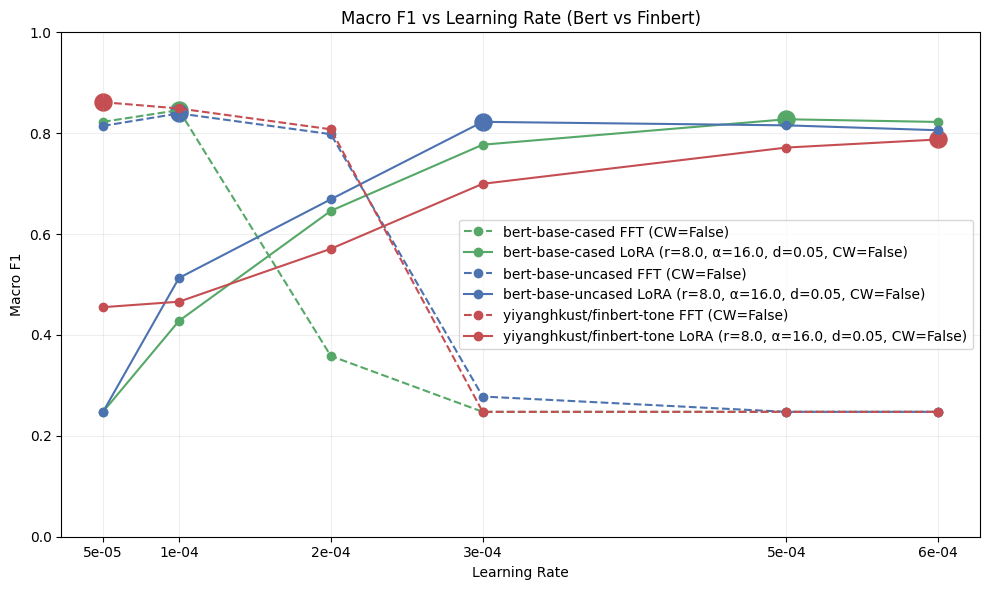

In [47]:
# ==========================================================
# 1️⃣ Learning Rate
# ==========================================================
plt.figure(figsize=(10,6)) 

for model in models:

    df = RESULTS_DF[RESULTS_DF["model"] == model]
    color = model_colors[model]

    fft_lr_df = df[df["experiment_type"].str.startswith("FFT_LR")].sort_values("learning_rate")
    lora_lr_df = df[df["experiment_type"].str.startswith("LORA_LR")].sort_values("learning_rate")
    
    if len(fft_lr_df) == 0 or len(lora_lr_df) == 0:
        continue

    # ---- Best LoRA ----
    best_lora_idx = lora_lr_df["f1"].idxmax()
    best_lora_lr = lora_lr_df.loc[best_lora_idx, "learning_rate"]
    best_lora_f1 = lora_lr_df.loc[best_lora_idx, "f1"]
    best_lora_rank = lora_lr_df.loc[best_lora_idx, "r"]
    best_lora_alpha = lora_lr_df.loc[best_lora_idx, "lora_alpha"]
    best_lora_dropout = lora_lr_df.loc[best_lora_idx, "lora_dropout"]
    best_lora_cw = lora_lr_df.loc[best_lora_idx, "use_class_weights"]

    # ---- Best FFT ----
    best_fft_idx = fft_lr_df["f1"].idxmax()
    best_fft_lr = fft_lr_df.loc[best_fft_idx, "learning_rate"]
    best_fft_f1 = fft_lr_df.loc[best_fft_idx, "f1"]
    best_fft_cw = fft_lr_df.loc[best_fft_idx, "use_class_weights"]
    
    # ---- Plot FFT ----
    plt.plot(
        fft_lr_df["learning_rate"],
        fft_lr_df["f1"],
        marker="o",
        linestyle="--",
        color=color,
        label=f"{model} FFT (CW={best_fft_cw})"
    )

    # ---- Plot LoRA ----
    plt.plot(
        lora_lr_df["learning_rate"],
        lora_lr_df["f1"],
        marker="o",
        linestyle="-",
        color=color,
        label=f"{model} LoRA (r={best_lora_rank}, α={best_lora_alpha}, d={best_lora_dropout}, CW={best_lora_cw})"
    )

    # ---- Highlight best points ----
    plt.scatter(best_fft_lr, best_fft_f1,
                s=150,
                color=color)

    plt.scatter(best_lora_lr, best_lora_f1,
                s=150,
                color=color)
    
    #add_labels(lora_lr_df["learning_rate"], lora_lr_df["f1"])
    #add_labels(fft_lr_df["learning_rate"], fft_lr_df["f1"])
    
# Collect all unique learning rates plotted
all_lrs = sorted(
    RESULTS_DF["learning_rate"].dropna().unique()
)

plt.xticks(all_lrs, [f"{lr:.0e}" for lr in all_lrs])
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0e}"))
finalize_plot("Macro F1 vs Learning Rate (Bert vs Finbert)", "Learning Rate")

Saved to ../outputs/macro_f1_vs_lora_rank_(r).png


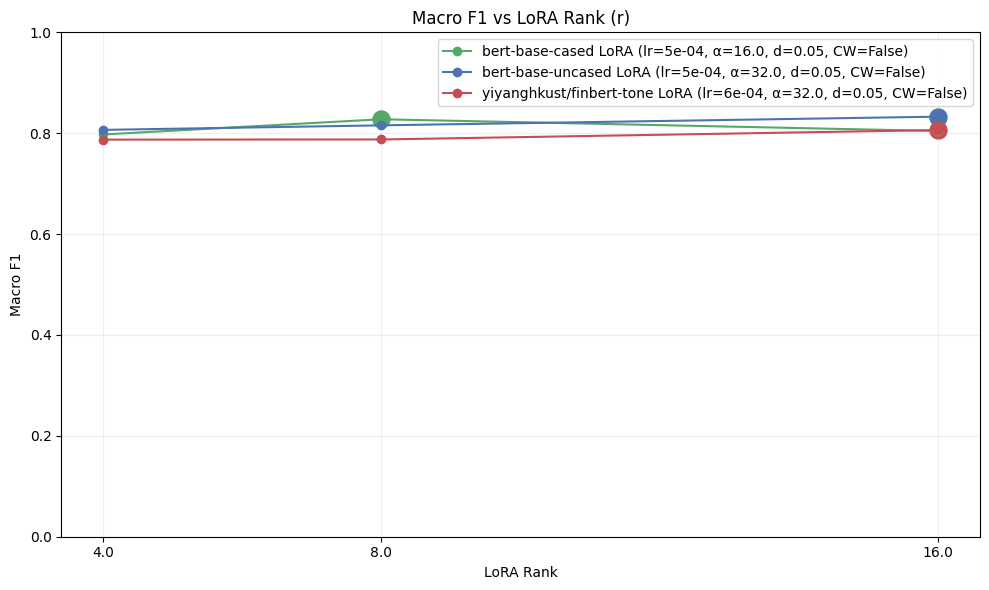

In [48]:
# ==========================================================
# 2️⃣ LoRA Rank
# ==========================================================
plt.figure(figsize=(10,6)) 

for model in models:

    df = RESULTS_DF[RESULTS_DF["model"] == model]
    color = model_colors[model]

    rank_df = df[df["experiment_type"].str.contains("LORA_RANK", na=False)].sort_values("r")

    if len(rank_df) == 0:
        continue

    # ---- Best LoRA ----
    best_lora_idx = rank_df["f1"].idxmax()
    best_lora_lr = rank_df.loc[best_lora_idx, "learning_rate"]
    best_lora_f1 = rank_df.loc[best_lora_idx, "f1"]
    best_lora_rank = rank_df.loc[best_lora_idx, "r"]
    best_lora_alpha = rank_df.loc[best_lora_idx, "lora_alpha"]
    best_lora_dropout = rank_df.loc[best_lora_idx, "lora_dropout"]
    best_lora_cw = rank_df.loc[best_lora_idx, "use_class_weights"]

    plt.plot(
        rank_df["r"],
        rank_df["f1"],
        marker="o",
        linestyle="-",
        color=color,
        label=f"{model} LoRA (lr={best_lora_lr:.0e}, α={best_lora_alpha}, d={best_lora_dropout}, CW={best_lora_cw})"
    )
    
    # ---- Highlight best points ----
    plt.scatter(best_lora_rank, best_lora_f1,
                s=150,
                color=color)
    
    #add_labels(rank_df["r"], rank_df["f1"])

# Collect all unique learning rates plotted
all_rs = sorted(
    RESULTS_DF["r"].dropna().unique()
)

plt.xticks(all_rs, [f"{r}" for r in all_rs])
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x}"))
finalize_plot("Macro F1 vs LoRA Rank (r)", "LoRA Rank")

Saved to ../outputs/macro_f1_vs_lora_alpha.png


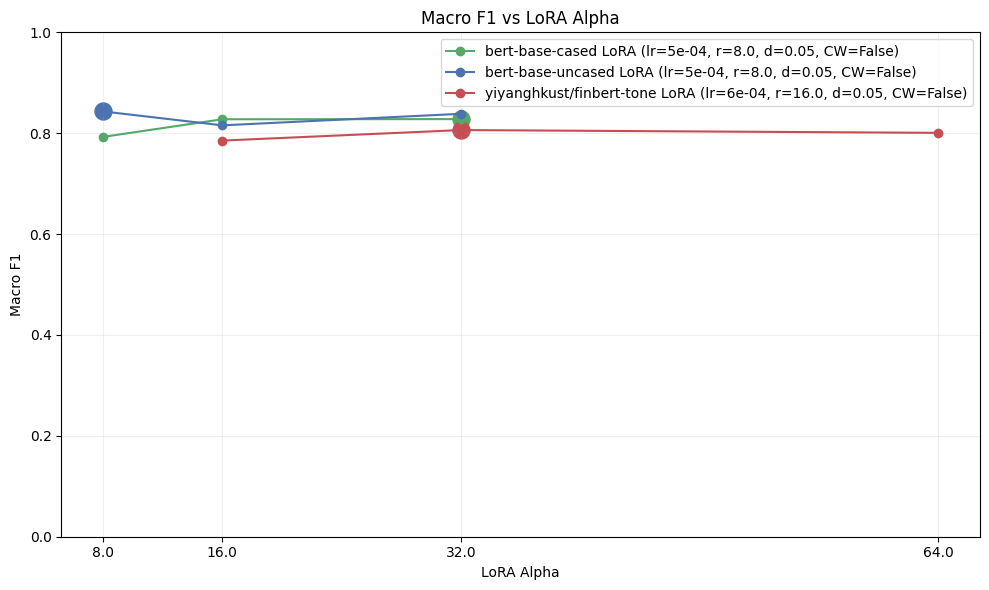

In [49]:
# ==========================================================
# 3️⃣ LoRA Alpha
# ==========================================================
plt.figure(figsize=(10,6)) 

for model in models:

    df = RESULTS_DF[RESULTS_DF["model"] == model]
    color = model_colors[model]

    alpha_df = df[df["experiment_type"].str.contains("LORA_ALPHA", na=False)].sort_values("lora_alpha")

    if len(alpha_df) == 0:
        continue

    # ---- Best LoRA ----
    best_lora_idx = alpha_df["f1"].idxmax()
    best_lora_lr = alpha_df.loc[best_lora_idx, "learning_rate"]
    best_lora_f1 = alpha_df.loc[best_lora_idx, "f1"]
    best_lora_rank = alpha_df.loc[best_lora_idx, "r"]
    best_lora_alpha = alpha_df.loc[best_lora_idx, "lora_alpha"]
    best_lora_dropout = alpha_df.loc[best_lora_idx, "lora_dropout"]
    best_lora_cw = alpha_df.loc[best_lora_idx, "use_class_weights"]

    plt.plot(
        alpha_df["lora_alpha"],
        alpha_df["f1"],
        marker="o",
        linestyle="-",
        color=color,
        label=f"{model} LoRA (lr={best_lora_lr:.0e}, r={best_lora_rank}, d={best_lora_dropout}, CW={best_lora_cw})"
    )

    # ---- Highlight best points ----
    plt.scatter(best_lora_alpha, best_lora_f1,
                s=150,
                color=color)
    
    #add_labels(alpha_df["lora_alpha"], alpha_df["f1"])

# Collect all unique learning rates plotted
all_alphas = sorted(
    RESULTS_DF["lora_alpha"].dropna().unique()
)

plt.xticks(all_alphas, [f"{alpha}" for alpha in all_alphas])
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x}"))
finalize_plot("Macro F1 vs LoRA Alpha", "LoRA Alpha")

Saved to ../outputs/macro_f1_vs_lora_dropout.png


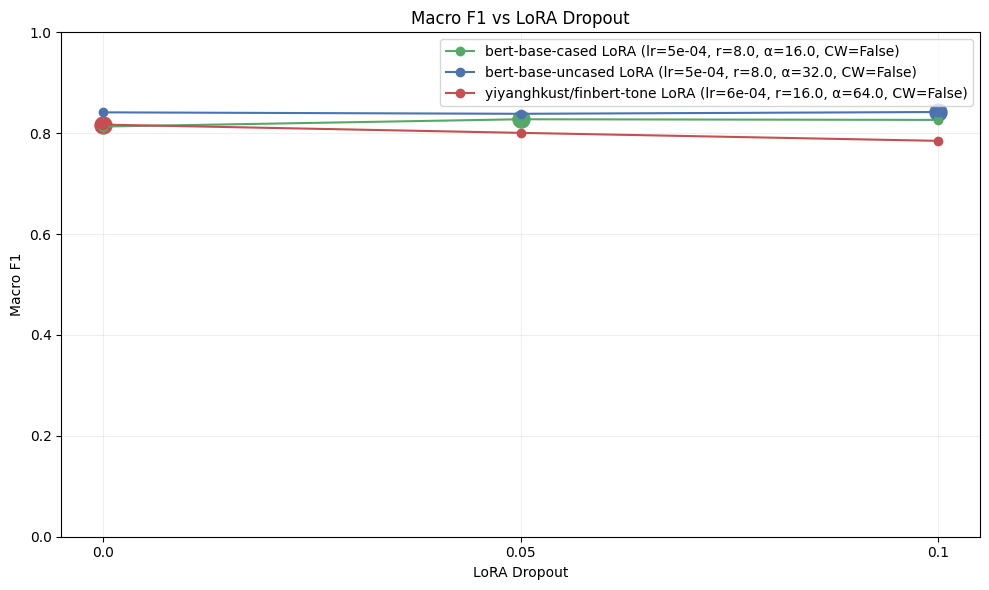

In [50]:
# ==========================================================
# 4️⃣ LoRA Dropout
# ==========================================================
plt.figure(figsize=(10, 6))

for model in models:

    df = RESULTS_DF[RESULTS_DF["model"] == model]
    color = model_colors[model]

    dropout_df = df[df["experiment_type"].str.contains("LORA_DROPOUT", na=False)].sort_values("lora_dropout")

    if len(dropout_df) == 0:
        continue

    # ---- Best LoRA ----
    best_lora_idx = dropout_df["f1"].idxmax()
    best_lora_lr = dropout_df.loc[best_lora_idx, "learning_rate"]
    best_lora_f1 = dropout_df.loc[best_lora_idx, "f1"]
    best_lora_rank = dropout_df.loc[best_lora_idx, "r"]
    best_lora_alpha = dropout_df.loc[best_lora_idx, "lora_alpha"]
    best_lora_dropout = dropout_df.loc[best_lora_idx, "lora_dropout"]
    best_lora_cw = dropout_df.loc[best_lora_idx, "use_class_weights"]

    plt.plot(
        dropout_df["lora_dropout"],
        dropout_df["f1"],
        marker="o",
        linestyle="-",
        color=color,
        label=f"{model} LoRA (lr={best_lora_lr:.0e}, r={best_lora_rank}, α={best_lora_alpha}, CW={best_lora_cw})"
    )

    # ---- Highlight best points ----
    plt.scatter(best_lora_dropout, best_lora_f1,
                s=150,
                color=color)
    
    #add_labels(dropout_df["lora_dropout"], dropout_df["f1"])

# Collect all unique learning rates plotted
all_ds = sorted(
    RESULTS_DF["lora_dropout"].dropna().unique()
)

plt.xticks(all_ds, [f"{d}" for d in all_ds])
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x}"))
finalize_plot("Macro F1 vs LoRA Dropout", "LoRA Dropout")

Saved to ../outputs/macro_f1_vs_class_weights.png


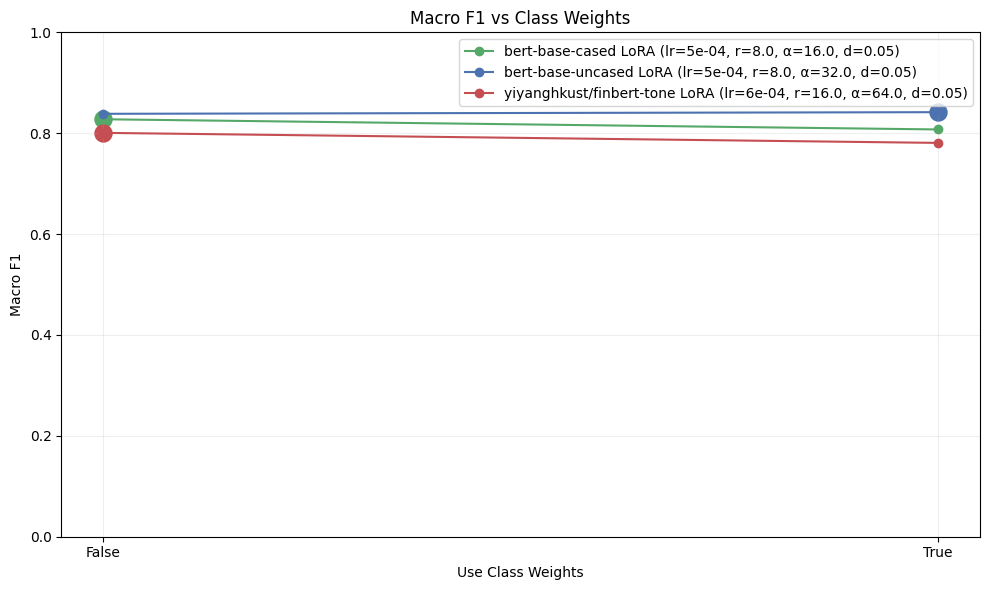

In [51]:
# ==========================================================
# 5️⃣ Class Weight
# ==========================================================
plt.figure(figsize=(10,6))

for model in models:

    df = RESULTS_DF[RESULTS_DF["model"] == model]
    color = model_colors[model]

    cw_df = df[df["experiment_type"].str.contains("CLASS_WEIGHT", na=False)]
    cw_group = cw_df.groupby("use_class_weights")["f1"].mean().sort_index()

    if len(cw_df) == 0:
        continue
            
    # ---- Best LoRA ----
    best_lora_idx = cw_df["f1"].idxmax()
    best_lora_lr = cw_df.loc[best_lora_idx, "learning_rate"]
    best_lora_f1 = cw_df.loc[best_lora_idx, "f1"]
    best_lora_rank = cw_df.loc[best_lora_idx, "r"]
    best_lora_alpha = cw_df.loc[best_lora_idx, "lora_alpha"]
    best_lora_dropout = cw_df.loc[best_lora_idx, "lora_dropout"]
    best_lora_cw = cw_df.loc[best_lora_idx, "use_class_weights"]

    plt.plot(
        cw_group.index.astype(str),
        cw_group.values,
        marker="o",
        linestyle="-",
        color=color,
        label=f"{model} LoRA (lr={best_lora_lr:.0e}, r={best_lora_rank}, α={best_lora_alpha}, d={best_lora_dropout})"
    )
    
    # ---- Highlight best points ----
    plt.scatter(best_lora_cw, best_lora_f1,
                s=150,
                color=color)
    
    #add_labels(cw_group.index.astype(str), cw_group.values)

finalize_plot("Macro F1 vs Class Weights", "Use Class Weights")

Plot saved to: ../outputs/model_comparison.png


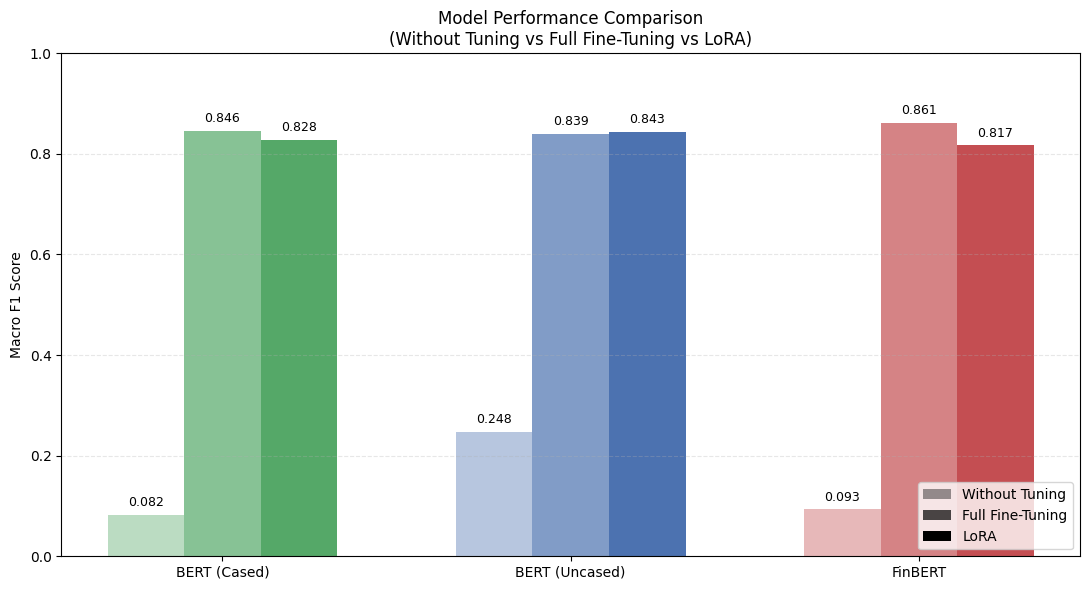

In [42]:
plt.figure(figsize=(11,6))

x = np.arange(len(models))
width = 0.22

baseline_scores = []
fft_scores = []
lora_scores = []

for model in models:
    df = RESULTS_DF[RESULTS_DF["model"] == model]

    baseline_scores.append(
        df[df["experiment_type"] == "baseline"]["f1"].max()
    )
    fft_scores.append(
        df[df["experiment_type"].str.contains("FFT", na=False)]["f1"].max()
    )
    lora_scores.append(
        df[df["experiment_type"].str.contains("LORA", na=False)]["f1"].max()
    )

# Plot grouped bars
for i, model in enumerate(models):
    color = model_colors.get(model, "gray")

    plt.bar(x[i] - width, baseline_scores[i], width,
            color=color, alpha=0.4)

    plt.bar(x[i], fft_scores[i], width,
            color=color, alpha=0.7)

    plt.bar(x[i] + width, lora_scores[i], width,
            color=color, alpha=1.0)

# Annotate values
for i in range(len(models)):
    scores = [baseline_scores[i], fft_scores[i], lora_scores[i]]
    offsets = [-width, 0, width]

    for score, offset in zip(scores, offsets):
        plt.annotate(
            f"{score:.3f}",
            xy=(x[i] + offset, score),
            xytext=(0, 4),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=9
        )

plt.ylabel("Macro F1 Score")
plt.title("Model Performance Comparison\n(Without Tuning vs Full Fine-Tuning vs LoRA)")
plt.xticks(x, [model_display[m] for m in models])
plt.ylim(0, 1)

plt.grid(axis="y", linestyle="--", alpha=0.3)

# Legend for training type
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='black', alpha=0.4, label='Without Tuning'),
    Patch(facecolor='black', alpha=0.7, label='Full Fine-Tuning'),
    Patch(facecolor='black', alpha=1.0, label='LoRA'),
]
plt.legend(handles=legend_elements, loc="lower right")

plt.tight_layout()

output_path = f"{OUTPUT_FOLDER}/model_comparison.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight", facecolor="white")
print(f"Plot saved to: {output_path}")
plt.show()